In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
import torchvision.models as models
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import os,cv2

In [2]:
!pip install efficientnet_pytorch #느낌표: 리눅스 명령어 
from efficientnet_pytorch import EfficientNet

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=cfd2e0bd8760107541fec407bb83b5cd4c00fbcc33f24d1219f1943d44f91e6c
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch
cuda


In [3]:
#여러개의 주소(여러개의 파라미터)를 받아서 전부 path에 추가후 반환해주는 함수
def collect_image_paths(*directories):
    paths = []
    for directory in directories:
        for dirname, _, filenames in os.walk(directory):
            for filename in filenames:
                if '.jpg' in filename:
                    file_path = os.path.join(dirname, filename)
                    paths.append(file_path)
    return paths


In [4]:
#os.walk를 이용하여 특정 디렉토리 밑에 있는 모든 하위 디렉토리 조사
directory1 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1'
directory2 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2'

paths=collect_image_paths(directory1,directory2)

# #총 길이 확인해보기
# num= 0;
# for path in paths:
#     num +=1
# print(num)


In [5]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in paths}

#imageid_path_dict = 사진이름 : 상대경로
# os.path.splitext(file_name) : 확장자 전까지의 파일이름과 확장자 분리해줌
# path가 폴더면 마지막 폴더명, 파일이면 마지막 파일명 (경로를 없애준다.)

lesion_type_dict = { 
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
} # 병명 매칭 위해 dict형태로 정의(없어도 상관없을듯?)

In [6]:
df_metadata = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv') # image와 label 매칭하기위해 metadata.csv불러옴

df_metadata['path'] = df_metadata['image_id'].map(imageid_path_dict.get) #'image_id'속성을 기준으로 같은것끼리 매핑해서 'path'속성에 붙힘 밑에도 같은 개념
df_metadata['les_type'] = df_metadata['dx'].map(lesion_type_dict.get)
df_metadata['les_type_idx'] = pd.Categorical(df_metadata['les_type']).codes
df_metadata.head() # 위에서부터 5개 보여줌

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,les_type,les_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,Benign keratosis-like lesions,2


In [7]:
directory3 = '/kaggle/input/acne-grading-classificationdataset/Created Dataset/Level_0'
directory4 = '/kaggle/input/acne-grading-classificationdataset/Created Dataset/Level_1'
directory5 = '/kaggle/input/acne-grading-classificationdataset/Created Dataset/Level_2'

paths2 = collect_image_paths(directory3,directory4,directory5)

# #총 길이 확인해보기
# num= 0;
# for path in paths2:
#     num +=1
# print(num)

list1=[]
list2=[]
list3=[]

for x in paths2:
    filename = os.path.basename(x)
    if filename.startswith('levle0'):
        new_row = { 'path': directory3 +'/'+ filename, 'les_type_idx': 7 }
        list1.append(new_row)
        
    elif filename.startswith('levle1'):
        new_row = { 'path': directory4 +'/'+ filename, 'les_type_idx': 8 }
        list2.append(new_row)
        
    elif filename.startswith('levle2'):
        new_row = { 'path': directory5 +'/'+ filename, 'les_type_idx': 9 }
        list3.append(new_row)
    
level1 = pd.DataFrame(list1)
level2 = pd.DataFrame(list2)
level3 = pd.DataFrame(list3)
df_metadata = pd.concat([df_metadata, level1], ignore_index=True)
df_metadata = pd.concat([df_metadata, level2], ignore_index=True)
df_metadata = pd.concat([df_metadata, level3], ignore_index=True)

print(df_metadata['les_type_idx'].value_counts().reset_index())


   les_type_idx  count
0             4   6705
1             6   1113
2             2   1099
3             1    514
4             8    473
5             7    387
6             0    327
7             5    142
8             9    120
9             3    115


In [8]:
list4=[]
directory6 = '/kaggle/input/myskin'

paths3 = collect_image_paths(directory6)

for x in paths3:
    new_row = { 'path': x, 'les_type_idx': 10 }
    list4.append(new_row)
    
myskin = pd.DataFrame(list4)
df_metadata = pd.concat([df_metadata, myskin], ignore_index=True)

In [9]:
print(df_metadata['les_type_idx'].value_counts().reset_index())

    les_type_idx  count
0              4   6705
1              6   1113
2              2   1099
3              1    514
4              8    473
5              7    387
6              0    327
7              5    142
8              9    120
9              3    115
10            10     39


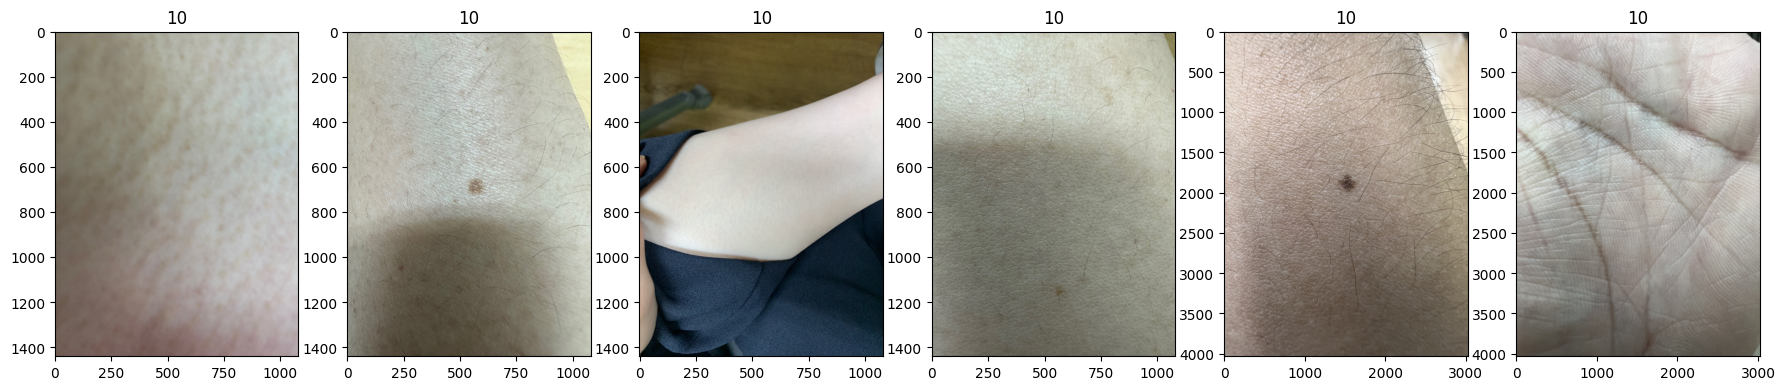

In [10]:
def show_grid_images(image_path_list, ncols=8, augmentor=None, title=None): # image visualizing용 함수
    figure, axs = plt.subplots(figsize=(22, 6), nrows=1, ncols=ncols)
    for i in range(ncols):
        image = cv2.cvtColor(cv2.imread(image_path_list[i]), cv2.COLOR_BGR2RGB)
        axs[i].imshow(image)
        axs[i].set_title(title)  
        
image_list = df_metadata[df_metadata['les_type_idx']==10]['path'].tolist() #조건[lesidx==n]에 해당하는 행의 ['path']값 리턴
show_grid_images(image_list, ncols=6, title='10') # title값은그냥 사진 위에 뜰 text를 뜻함,실제 label값아님

In [11]:
def CreateModel(model_name, num_classes):
    if model_name == 'resnet':
        model = models.resnet50(pretrained=True)
        model.fc = torch.nn.Linear(model.fc.in_features, num_classes) # Replace the final fully connected layer
        model.to(device)
        IMG_SIZE=224
    
    elif model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, num_classes)
        model.to(device)
        IMG_SIZE=224
    
    elif model_name == 'inception-v3': #299x299
        model = models.inception_v3(pretrained=True)
        model.fc = torch.nn.Linear(model.fc.in_features, num_classes) # Replace the main fully connected layer

        # Replace the auxiliary fully connected layer if you plan to use the auxiliary output
        model.AuxLogits.fc = torch.nn.Linear(model.AuxLogits.fc.in_features, num_classes)
        model.to(device)
        IMG_SIZE=299
    
    elif model_name == 'mobilenet':
        model = models.mobilenet_v2(pretrained=True)
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)
        model.to(device)
        IMG_SIZE=224
    
    elif model_name == 'efficientnet':
        model = models.efficientnet_b0(pretrained=True)
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)
        model.to(device)
        IMG_SIZE=224
     
    elif model_name == 'efficientnet_b3' : #300x300
        model = EfficientNet.from_pretrained('efficientnet-b3')
#         model = EfficientNet.from_name('efficientnet-b3')
        num_ftrs = model._fc.in_features
        model._fc = torch.nn.Linear(num_ftrs, num_classes)
#         model._fc = nn.Sequential(
#             nn.Dropout(p=0.5),  
#             nn.Linear(num_ftrs, num_classes)
#             )
        model.to(device)
        IMG_SIZE=300

    
    elif model_name == 'efficientnet_b7' : #원랜 600x600
        model = EfficientNet.from_pretrained('efficientnet-b7')
        num_ftrs = model._fc.in_features
        model._fc = torch.nn.Linear(num_ftrs, num_classes)
        model.to(device)
        IMG_SIZE=256
    
    return model,IMG_SIZE

res_acc, vgg_acc, inc_acc, mob_acc, effb0_acc, effb3_acc = [],[],[],[],[],[]

#ResNet
#VGG16
#Inception-v3
#MobileNet
#EfficientNet 높은버전

In [12]:
# model ,IMG_SIZE = CreateModel('resnet', 11)
# model ,IMG_SIZE = CreateModel('vgg16', 11)
# model ,IMG_SIZE = CreateModel('inception-v3', 11)
# model ,IMG_SIZE = CreateModel('mobilenet', 11)
# model ,IMG_SIZE = CreateModel('efficientnet', 11)
model ,IMG_SIZE = CreateModel('efficientnet_b3', 11)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 242MB/s]


Loaded pretrained weights for efficientnet-b3


In [13]:
learning_rate= 0.0005 #이건 직접 작성 필요
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.001)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
batch_size = 16
epochs = 10
criterion = nn.CrossEntropyLoss() 

In [14]:
class CustomDataset(Dataset): # 상속받은 Dataset의 기본틀 : __init__(), __getitem__(), __len__()을 각각 오버라이딩 해주어야함
    def __init__(self, df, transforms=None): #생성자
        self.x = df['path'].values
        self.y = df['les_type_idx'].values
        self.transforms = transforms
        
    def __getitem__(self, index): # index값으로 data접근시 반환로직
        img_path = self.x[index]
        image = cv2.imread(img_path) # path값을 image로 읽어서 (cv2:Opencv라이브러리)
        
        if self.transforms is not None: 
            image = self.transforms(image) # 밑에 정의한 transforms 적용
            
        label = self.y[index]
        return image, label # 변환된 이미지,label값 리턴
    
    def __len__(self):
        return len(self.x) # 얘는그냥 길이 리턴

In [15]:
class CustomDataset(Dataset): # 상속받은 Dataset의 기본틀 : __init__(), __getitem__(), __len__()을 각각 오버라이딩 해주어야함
    def __init__(self, df, transforms=None): #생성자
        self.x = df['path'].values
        self.y = df['les_type_idx'].values
        self.transforms = transforms
        
    def __getitem__(self, index): # index값으로 data접근시 반환로직
        img_path = self.x[index]
        image = cv2.imread(img_path) # path값을 image로 읽어서 (cv2:Opencv라이브러리)
        
        if self.transforms is not None: 
            image = self.transforms(image) # 밑에 정의한 transforms 적용
            
        label = self.y[index]
        return image, label # 변환된 이미지,label값 리턴
    
    def __len__(self):
        return len(self.x) # 얘는그냥 길이 리턴

In [16]:
transform = T.Compose([ # 이미지 조정(사이즈맞추기, tensor로 타입바꾸기)
    T.ToPILImage(),
    T.Resize((IMG_SIZE,IMG_SIZE)),
    T.ToTensor(),
])
train_transforms = T.Compose([
    T.ToPILImage(),
    T.CenterCrop(500),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(p=0.5),  # 50% 확률로 좌우 뒤집기
    T.RandomRotation(degrees=15),   # -15도에서 15도 사이로 회전
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize은 이미지를 Tensor로 변환한 후에 적용해야 합니다
])

In [17]:
dataset = CustomDataset(df_metadata, transform) #이거 나중에 파라미터로 써야하니까, 반드시 해줘야함

In [18]:
def apply_transforms_in_batches(data, transform_func, batch_size, target_label=10):
    data_list = list(data)  # Convert tuple to list
    num_batches = len(data_list) // batch_size + (1 if len(data_list) % batch_size != 0 else 0)
    
    for batch_idx in tqdm(range(num_batches)):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(data_list))  # Ensure end_idx does not exceed list length
        batch = data_list[start_idx:end_idx]

        for i in range(len(batch)):
            image, label = batch[i]
            if label == target_label:
                transformed_image = transform_func(image)
                data_list[start_idx + i] = (transformed_image, label)  # Replace with transformed image
    
    return tuple(data_list)

In [19]:
#데이터셋을 준비해주는 함수 (모듈화)
def prepare_dataset(dataset, batch_size=32, train_transforms=None):
    
    #사이즈 정하는 곳
    dataset_size = len(dataset)
    train_size = int(dataset_size * 0.8)
    val_size = int(dataset_size * 0.1)
    test_size = dataset_size - train_size - val_size
    
    train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])
    
    
    train_data = apply_transforms_in_batches(train_data, train_transforms, 128,10)
 
    
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    return train_dataloader, val_dataloader, test_dataloader, test_data

In [20]:
# 학습 및 검증 함수 (파라미터로 들어가는건 사전에 만들어서 넣어야 함)
def train_and_validate(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=10,train_losses=None, valid_losses=None,accuracy=None):
    min_val_loss = np.inf # min_val_loss = float('inf')
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_corrects=0.0 #추가
        train_acc = 0.0
        for inputs, labels in tqdm(train_dataloader):
            inputs, labels = inputs.to(device), labels.type(torch.LongTensor).to(device)
            
            outputs = model(inputs)
#             outputs = outputs.logits              # model = inception 용, 다른모델일땐 주석처리해야함
            preds = torch.argmax(outputs, 1)
            loss = criterion(outputs, labels)
            
            #역전파
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_acc += torch.sum(preds == labels.data).detach().cpu().numpy()/inputs.size(0)
        

        # Validation phase
        val_loss = 0.0
        val_corrects=0.0
        val_acc = 0.0
        model.eval()
        for inputs, labels in tqdm(val_dataloader):
            inputs, labels = inputs.to(device), labels.type(torch.LongTensor).to(device)

            outputs = model(inputs)
            preds = torch.argmax(outputs, 1)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            val_acc += torch.sum(preds == labels.data).detach().cpu().numpy()/inputs.size(0)
            


        if val_loss < min_val_loss:
            print(f'\nValidation Loss Decreased ({min_val_loss:.3f} ---> {val_loss:.3f}) \t Saving The Model\n')
            min_val_loss = val_loss
            torch.save(model.state_dict(), 'saved_model.pth') # Saving State Dict
        
        
        train_losses.append(train_loss / len(train_dataloader))
        valid_losses.append(val_loss / len(val_dataloader))
        accuracy.append(val_acc / len(val_dataloader))

        print("Epoch:{}/{}..".format(epoch + 1, epochs),
              "Train Loss: {:.3f}..".format(train_loss / len(train_dataloader)),
              "Val Loss: {:.3f}..".format(val_loss / len(val_dataloader)),
              "Train Acc:{:.3f}..".format(train_acc / len(train_dataloader)),
              "Val Acc:{:.3f}..\n".format(val_acc / len(val_dataloader)))
        
        

    return train_losses, valid_losses, accuracy


In [21]:
def test_model(model, test_dataloader, test_data):
    model.load_state_dict(torch.load('saved_model.pth')) #가장 좋은 거 가져옴
    with torch.no_grad():   
        model.eval()
        total_samples = 0.0
        correct_samples = 0.0
        for x, y in tqdm(test_dataloader):
            x, y = x.to(device), y.type(torch.LongTensor).to(device)
            out = model(x)              
            pred = torch.argmax(out, 1)
            correct_samples += (pred == y).sum()  # 예측에 성공한 값들 모아서
    print('Accuracy: %.3f' %(100*float(correct_samples) / float(len(test_data))))   # 전체값으로 나눠 accuracy프린트 

In [22]:
# 테스트하고, 그 결과를 시각화하는 함수
def visualize_test_results(test_dataloader, model, device, img_size, batch_size=32, num_samples=12):
    test_data, test_labels = next(iter(test_dataloader))
    if torch.cuda.is_available():
        test_data, test_labels = test_data.to(device), test_labels.to(device)
        out = model(test_data)
        pred = torch.argmax(out, 1)
    
    sample_index = np.random.choice(batch_size, size=num_samples)
    random_samples = test_data[sample_index].cpu().numpy()
    
    plt.figure(figsize=(12, 12))
    
    for k in range(num_samples):
        plt.subplot(4, 4, k + 1)
        plt.imshow(random_samples[k].reshape(3, img_size, img_size).transpose(1, 2, 0) / 2 + 0.5)
        plt.title("True: " + str(test_labels[sample_index[k]].item()) + "\nPred: " + str(pred[sample_index[k]].item()))
        plt.axis('off')
    
    plt.show()

In [23]:
def show_accuracy(*models_acc):
    models=['resnet', 'vgg16', 'inception-v3', 'mobilenet', 'efficientnet_B0', 'efficientnet_B3']
    plt.figure(figsize=(8, 4))
    plt.yticks(np.arange(0, 1, 0.01))
    plt.xticks(np.arange(0, 20, 1))
    
    for index, acc in enumerate(models_acc):
        acc = np.array(acc)
        #plt.plot(acc, label=models[index])
        plt.plot(acc, label = "accuracy")

    plt.legend()

In [24]:
def show_losses(train_losses, valid_losses):
    plt.figure(figsize=(8, 4))
    plt.yticks(np.arange(0, 50, 5))
    plt.xticks(np.arange(0, 20, 1))
    
    train_lose = np.array(train_losses.detach().numpy())
    valid_lose = np.array(valid_losses)
    plt.plot(train_loss, label="train_loss")
    plt.plot(valid_loss, label="valid_loss")

    plt.legend()

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/552 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]


Validation Loss Decreased (inf ---> 114.968) 	 Saving The Model

Epoch:1/10.. Train Loss: 1.874.. Val Loss: 1.666.. Train Acc:0.536.. Val Acc:0.616..



  0%|          | 0/552 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]


Validation Loss Decreased (114.968 ---> 95.414) 	 Saving The Model

Epoch:2/10.. Train Loss: 1.358.. Val Loss: 1.383.. Train Acc:0.635.. Val Acc:0.629..



  0%|          | 0/552 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]


Validation Loss Decreased (95.414 ---> 84.209) 	 Saving The Model

Epoch:3/10.. Train Loss: 1.201.. Val Loss: 1.220.. Train Acc:0.646.. Val Acc:0.640..



  0%|          | 0/552 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]


Validation Loss Decreased (84.209 ---> 80.125) 	 Saving The Model

Epoch:4/10.. Train Loss: 1.126.. Val Loss: 1.161.. Train Acc:0.655.. Val Acc:0.659..



  0%|          | 0/552 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]


Validation Loss Decreased (80.125 ---> 75.973) 	 Saving The Model

Epoch:5/10.. Train Loss: 1.073.. Val Loss: 1.101.. Train Acc:0.659.. Val Acc:0.659..



  0%|          | 0/552 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]


Validation Loss Decreased (75.973 ---> 72.943) 	 Saving The Model

Epoch:6/10.. Train Loss: 1.025.. Val Loss: 1.057.. Train Acc:0.666.. Val Acc:0.667..



  0%|          | 0/552 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]


Validation Loss Decreased (72.943 ---> 69.874) 	 Saving The Model

Epoch:7/10.. Train Loss: 0.986.. Val Loss: 1.013.. Train Acc:0.672.. Val Acc:0.667..



  0%|          | 0/552 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]


Validation Loss Decreased (69.874 ---> 67.126) 	 Saving The Model

Epoch:8/10.. Train Loss: 0.954.. Val Loss: 0.973.. Train Acc:0.677.. Val Acc:0.677..



  0%|          | 0/552 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]


Validation Loss Decreased (67.126 ---> 66.097) 	 Saving The Model

Epoch:9/10.. Train Loss: 0.931.. Val Loss: 0.958.. Train Acc:0.679.. Val Acc:0.681..



  0%|          | 0/552 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]


Validation Loss Decreased (66.097 ---> 63.931) 	 Saving The Model

Epoch:10/10.. Train Loss: 0.902.. Val Loss: 0.927.. Train Acc:0.685.. Val Acc:0.679..



  0%|          | 0/69 [00:00<?, ?it/s]

Accuracy: 69.565


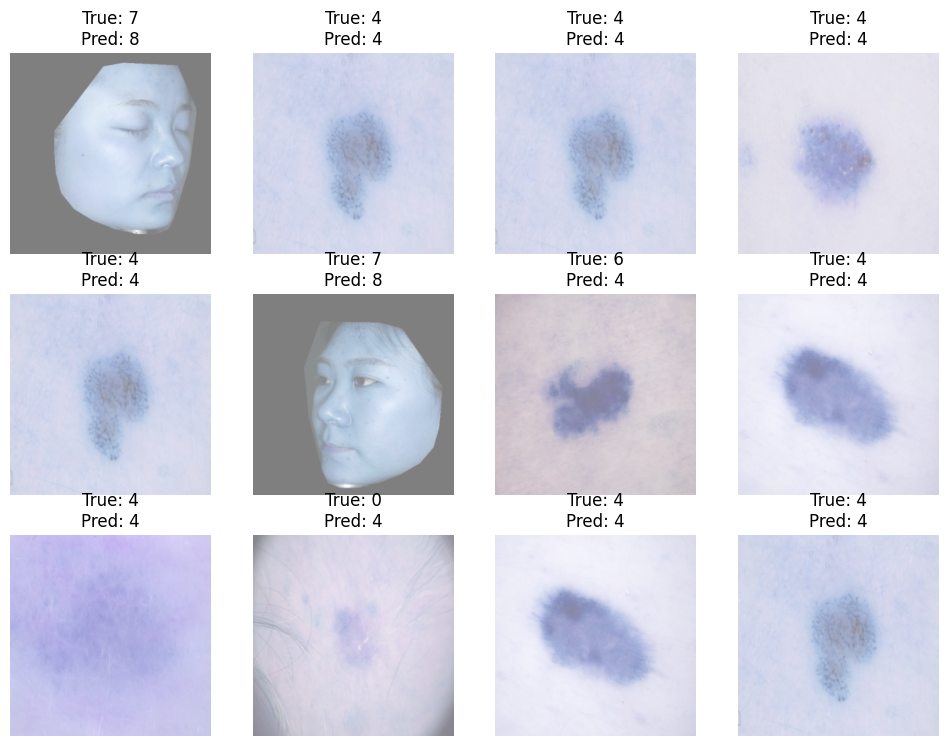

In [25]:
train_losses, valid_losses =[], []
accuracy=[]

# 데이터셋 준비
train_dataloader, val_dataloader, test_dataloader, test_data = prepare_dataset(dataset,batch_size,train_transforms)

# 학습 및 검증 실행
train_losses ,valid_losses, accuracy = train_and_validate(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=epochs, train_losses=train_losses, valid_losses=valid_losses,accuracy=accuracy)
# train_and_validate(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=epochs, train_losses=train_losses, valid_losses=valid_losses)

# test phase
test_model(model, test_dataloader, test_data)

visualize_test_results(test_dataloader, model, device, IMG_SIZE,batch_size)

[0.6164251207729469, 0.6291062801932367, 0.6400966183574879, 0.6590579710144928, 0.6591183574879227, 0.6671497584541063, 0.6672705314009661, 0.6772946859903382, 0.6806763285024154, 0.6791666666666666]


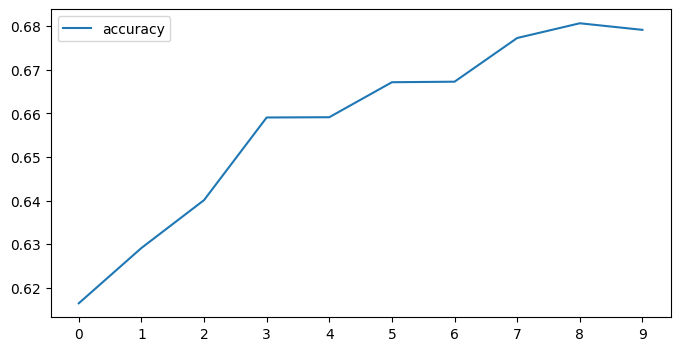

In [26]:
print(accuracy)
show_accuracy(accuracy)

In [27]:
from IPython.display import FileLink
FileLink(r'saved_model.pth')

/kaggle/working/saved_model.pth

In [28]:
# classes_dict = { 
#     0 : 'Actinic keratoses',
#     1 : 'Dermatofibroma',
#     2 : 'Benign keratosis-like lesions ',
#     3 : 'Basal cell carcinoma',
#     4 : 'Melanocytic nevi',
#     5 : 'Vascular lesions',
#     6 : 'dermatofibroma',
#     7 : 'acne_1',
#     8 : 'acne_2',
#     9 : 'acne_3',
#     10 : 'normal'
# }

# x = '/kaggle/input/fortest/test_1.jpg'
# x = cv2.imread(x)
# x = transform(x)
# x = x.unsqueeze(0)
# x = x.to(device)
# out = model(x)              
# pred = torch.argmax(out, 1)
# print("predicted class : "+ classes_dict[int(pred)])

In [29]:
def show_losses(train_losses, valid_losses):
    plt.figure(figsize=(8, 4))
    plt.yticks(np.arange(0, 1, 0.1))
    plt.xticks(np.arange(0, 20, 1))
    
    plt.plot(train_losses, label="train_loss")
    plt.plot(valid_losses, label="valid_loss")

    plt.legend()

[1.874104316683783, 1.3579241851533668, 1.2005367910732394, 1.1264326089750165, 1.0726392090968464, 1.025189449713714, 0.9860949514676696, 0.9538650758888411, 0.9311526626672434, 0.9024768638006155] [1.6661994215370952, 1.3828146129414656, 1.220419571019601, 1.161232844642971, 1.101059767647066, 1.0571465582951256, 1.0126604122528131, 0.9728460683338884, 0.9579281552114348, 0.9265337253826252]


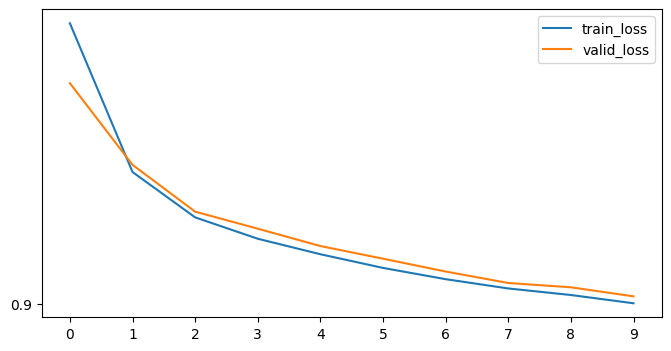

In [30]:
print(train_losses ,valid_losses)
show_losses(train_losses ,valid_losses)

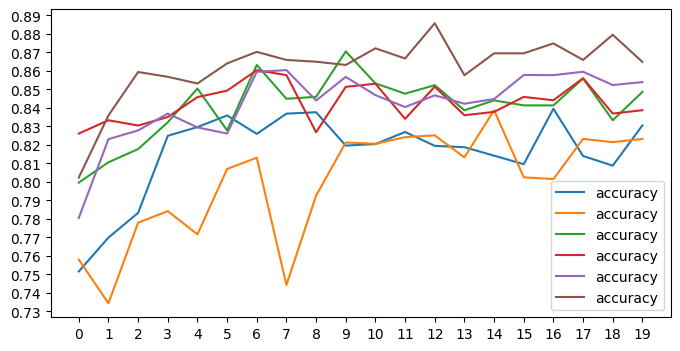

In [31]:
res_acc=[0.7515700483091787, 0.769867149758454, 0.7832125603864734, 0.8248792270531401, 0.8295893719806763, 0.8358695652173913, 0.8259057971014492, 0.8368357487922705, 0.8376207729468599, 0.8195652173913043, 0.8204106280193237, 0.8269323671497584, 0.8194444444444444, 0.818719806763285, 0.8141304347826086, 0.8095410628019324, 0.8394927536231883, 0.8139492753623189, 0.808756038647343, 0.8304951690821256]

vgg_acc=[0.7579710144927536, 0.7343599033816425, 0.7778985507246376, 0.7841787439613527, 0.7716183574879227, 0.8069444444444445, 0.8130434782608695, 0.7442632850241545, 0.792512077294686, 0.821256038647343, 0.8205314009661836, 0.8241545893719807, 0.8251207729468598, 0.8132246376811594, 0.838707729468599, 0.8024154589371981, 0.8015096618357488, 0.8231884057971014, 0.8214371980676328, 0.8231884057971014]

inc_acc=[0.7995772946859904, 0.8105676328502416, 0.8176932367149758, 0.8321859903381643, 0.8504227053140097, 0.8277777777777778, 0.8631642512077294, 0.8448671497584541, 0.8459541062801932, 0.8704710144927537, 0.8532004830917874, 0.8476449275362319, 0.8522342995169082, 0.8386473429951691, 0.8440217391304348, 0.8413043478260869, 0.8413043478260869, 0.8558574879227053, 0.8332729468599034, 0.8486111111111111]

mob_acc=[0.8260869565217391, 0.8332729468599034, 0.8304347826086956, 0.835024154589372, 0.8457729468599033, 0.8492753623188406, 0.8603260869565217, 0.8576690821256039, 0.8268115942028985, 0.851328502415459, 0.8530193236714976, 0.8340579710144927, 0.8514492753623188, 0.8359903381642512, 0.8378019323671497, 0.8458937198067633, 0.8440821256038648, 0.8559782608695652, 0.8368961352657004, 0.838707729468599]

effib0_acc=[0.7804951690821256, 0.8230676328502415, 0.8277777777777778, 0.8368961352657004, 0.8294082125603864, 0.8260869565217391, 0.8594202898550725, 0.8603864734299517, 0.8439613526570049, 0.8567028985507246, 0.8468599033816424, 0.8403985507246376, 0.8467391304347825, 0.8422101449275362, 0.8447463768115943, 0.8577294685990338, 0.8576690821256039, 0.8594806763285024, 0.8522946859903381, 0.8539251207729469]

effib3_acc=[0.8022946859903382, 0.8358695652173913, 0.8593599033816425, 0.8567632850241546, 0.8531400966183575, 0.8640096618357488, 0.8702294685990338, 0.8658816425120772, 0.8649154589371981, 0.8631642512077294, 0.8721618357487922, 0.8666666666666666, 0.8856884057971014, 0.8576086956521739, 0.8694444444444445, 0.8694444444444445, 0.8748188405797102, 0.8658816425120772, 0.8794685990338164, 0.8647946859903382]

show_accuracy(res_acc, vgg_acc, inc_acc, mob_acc, effib0_acc, effib3_acc)